#### Progetto di corso per APPLICAZIONI DELL'INTELLIGENZA ARTIFICIALE (AA 2024-2025)
#### Stud: Marzio Della Bosca


Jupyter Notebook con la funzione di estrarre le feature, tramite catch22 e tsfel, dai dati contenuti nel dataset [WISDM](https://archive.ics.uci.edu/dataset/507/wisdm%2Bsmartphone%2Band%2Bsmartwatch%2Bactivity%2Band%2Bbiometrics%2Bdataset)

In [1]:
import tsfel
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import os
from aeon.transformations.collection.feature_based import Catch22
import matplotlib.pyplot as plt
import random as rnd

# Walking A - Jogging B - Stairs C - Sitting D - Standing E - Typing F - Brushing Teeth G - Eating Soup H 
# Eating Chips I - Eating Pasta J - Drinking G - Watch K - Eating Sandwich L - Kicking (Soccer Ball) M 
# Playing Catch w - Tennis Ball O - Dribblinlg (Basketball) P - Writing Q - Clapping R - Folding Clothes S

# di queste decido di fare inferenza per le classi:

# Walking A - Jogging B - Stairs C - Sitting D - Standing E

In [25]:
def catch22_time_series_features_extractor(time_series):
    catch22 = Catch22()
    startTime = time.time()

    # Numero di feature Catch22 per canale (prendo il primo segnale x_acc)
    test_features = catch22.fit_transform([np.array(time_series.iloc[0]['x_acc'])])[0]
    n_feat = len(test_features)
    n_channels = 6  # x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr

    # Preallocazione array 3D (serie, canali, feature)
    features_3d = np.zeros((len(time_series), n_channels, n_feat))
    activities = []

    channels = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']

    for i, (_, series) in enumerate(tqdm(time_series.iterrows(), total=len(time_series), desc="Estrazione Catch22")):
        for j, ch in enumerate(channels):
            signal = np.array(series[ch])
            features_3d[i, j, :] = catch22.fit_transform([signal])[0]
        activities.append(series['activity'])

    activities_array = np.array(activities)

    print(f"Tempo di esecuzione per l'estrazione delle feature catch22: {time.time() - startTime:.2f} secondi")
    return features_3d, activities_array

def tsfel_time_series_features_extractor_dual(cfg_stat, cfg_temp, time_series):
    timeStart = time.time()

    # Determina il numero di feature per configurazione e canale usando la prima serie e primo canale
    test_feats_stat = tsfel.time_series_features_extractor(cfg_stat, pd.DataFrame(np.array(time_series.iloc[0]['x_acc'])), verbose=0)
    n_feat_stat = test_feats_stat.shape[1]

    test_feats_temp = tsfel.time_series_features_extractor(cfg_temp, pd.DataFrame(np.array(time_series.iloc[0]['x_acc'])), verbose=0)
    n_feat_temp = test_feats_temp.shape[1]

    n_channels = 6  # x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr

    # Prealloca array per feature (stat + temp)
    features_3d = np.zeros((len(time_series), n_channels, n_feat_stat + n_feat_temp))
    activities = []

    channels = ['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr']

    for i, (_, series) in enumerate(tqdm(time_series.iterrows(), total=len(time_series), desc="Estrazione TSFEL")):
        for j, ch in enumerate(channels):
            signal = pd.DataFrame(np.array(series[ch]))  # Serie temporale canale
            feats_stat = tsfel.time_series_features_extractor(cfg_stat, signal, verbose=0, n_jobs=-1)
            feats_temp = tsfel.time_series_features_extractor(cfg_temp, signal, verbose=0, n_jobs=-1)
            # Concateno le feature stat + temp
            combined_feats = np.concatenate((feats_stat.values.flatten(), feats_temp.values.flatten()))
            features_3d[i, j, :] = combined_feats
        activities.append(series['activity'])

    print(f"Tempo di esecuzione per l'estrazione delle feature tsfel 3D: {time.time() - timeStart:.2f} secondi")

    activities_array = np.array(activities)
    return features_3d, activities_array

In [3]:
# estraggo accellerazioni (acc) e relativiti timestamp, ogni file sono 3 minuti per attività
dfs_acc = []
for i in range(1600, 1651):
    filename = f"./WISDM_data/data_{i}_accel_phone.txt"
    df_temp = pd.read_csv(filename, header=None, names=['user', 'classe', 'timestamp', 'acc_x', 'acc_y', 'acc_z'])
    df_temp['acc_z'] = df_temp['acc_z'].astype(str).str.rstrip(';').astype(float)
    df_temp = df_temp[['timestamp', 'classe', 'acc_x', 'acc_y', 'acc_z']]
    dfs_acc.append(df_temp)
    
df_acc_f = pd.concat(dfs_acc, ignore_index=True)
df_acc_f = pd.DataFrame(df_acc_f)
print(f"Numero esempi da accellerazioni: {len(df_acc_f)}")
print(f"{df_acc_f.head()}")

Numero esempi da accellerazioni: 4804403
         timestamp classe     acc_x      acc_y     acc_z
0  252207666810782      A -0.364761   8.793503  1.055084
1  252207717164786      A -0.879730   9.768784  1.016998
2  252207767518790      A  2.001495  11.109070  2.619156
3  252207817872794      A  0.450623  12.651642  0.184555
4  252207868226798      A -2.164352  13.928436 -4.422485


In [4]:
dfs_gyr = []
for i in range(1600, 1651):
    filename = f"./WISDM_data/data_{i}_gyro_phone.txt"
    df_temp = pd.read_csv(filename, header=None, names=['user', 'classe', 'timestamp', 'acc_x', 'acc_y', 'acc_z'])
    df_temp['acc_z'] = df_temp['acc_z'].astype(str).str.rstrip(';').astype(float)
    df_temp = df_temp[['timestamp', 'classe', 'acc_x', 'acc_y', 'acc_z']]
    dfs_gyr.append(df_temp)
    
df_gyr_f = pd.concat(dfs_gyr, ignore_index=True)
df_gyr_f = pd.DataFrame(df_gyr_f)
print(f"Numero esempi da rotazioni: {len(df_gyr_f)}")
print(f"{df_gyr_f.head()}")

Numero esempi da rotazioni: 3608635
         timestamp classe     acc_x     acc_y     acc_z
0  252207918580802      A -0.853210  0.297226  0.890182
1  252207968934806      A -0.875137  0.015472  0.162231
2  252208019288809      A -0.720169  0.388489 -0.284012
3  252208069642813      A -0.571640  1.227402 -0.241669
4  252208119996817      A -0.380493  1.202835 -0.213135


Differenza media tra timestamp: 29242705.213994548
Numero campioni con gap significativo:
558
Differenza media tra timestamp: 21964542.549357444
Numero campioni con gap significativo:
667


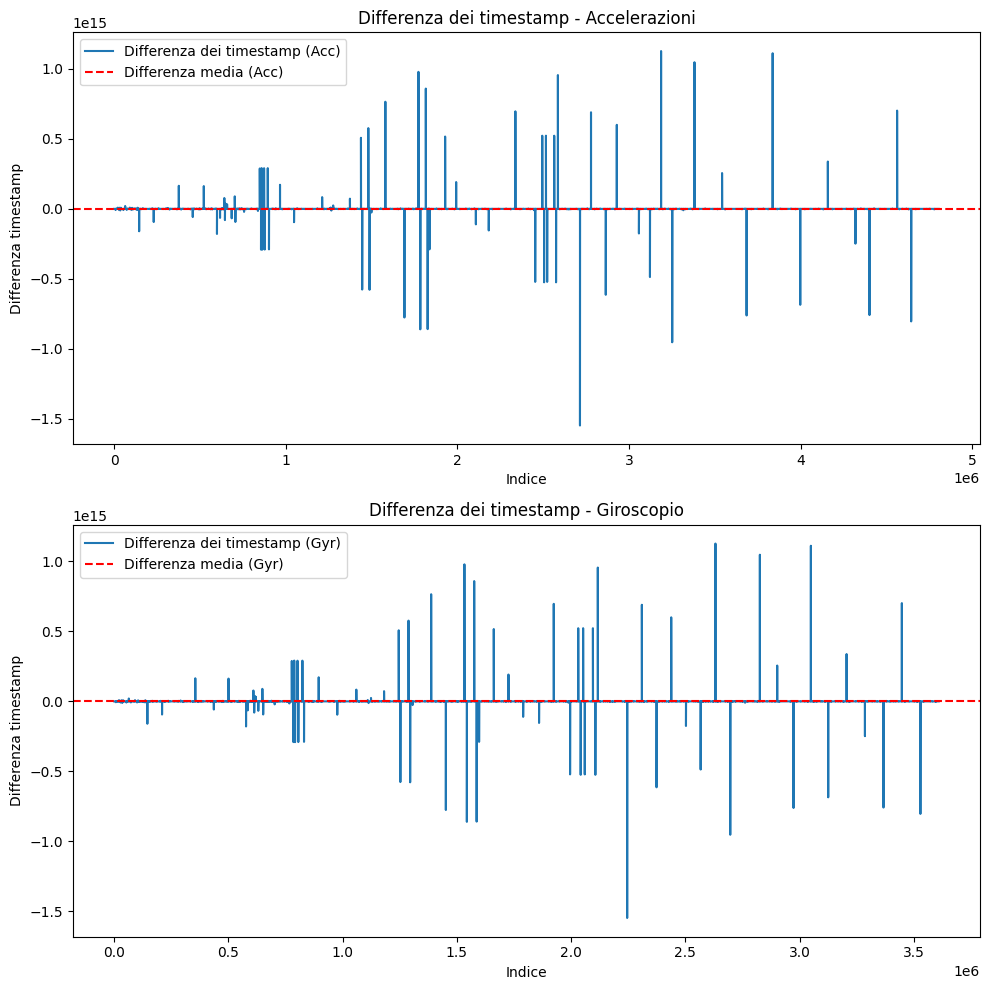

In [ ]:
# Anche se diverse prove mostrano sia in head che in tail che i creation time dei dati di giroscopio e accelerometro sembrano combaciare si nota un'importante mancanza di 
# campioni dal giroscopio, inoltre sono stati usati diversi cellulari. Mi baso sul fatto che ogni file sono 3 minuti di registrazioni
#Come si evince dal plot sembra che il giroscopio abbia perso campioni rispetto al accellerometro durante tutta la durata delle registrazioni

# Calcola differenza tra timestamp consecutivi per i dati del giroscopio
time_diff_gyr = df_gyr_f['timestamp'].diff()

# Calcola differenza media
avg_diff_gyr = time_diff_gyr.mean()
print("Differenza media tra timestamp:", avg_diff_gyr)

# Individua valori che superano 2 o 3 volte la differenza media
gap_threshold = 3 * avg_diff_gyr
gaps = df_gyr_f[time_diff_gyr > gap_threshold]
print("Numero campioni con gap significativo:")
print(len(gaps))

# Calcola la differenza tra timestamp consecutivi per i dati del giroscopio
time_diff_acc = df_acc_f['timestamp'].diff()

# Calcola la differenza media
avg_diff_acc = time_diff_acc.mean()
print("Differenza media tra timestamp:", avg_diff_acc)

gap_threshold = 3 * avg_diff_acc
gaps = df_acc_f[time_diff_acc > gap_threshold]
print("Numero campioni con gap significativo:")
print(len(gaps))

plt.figure(figsize=(10, 10))  

plt.subplot(2, 1, 1)  
plt.plot(time_diff_acc.values, label='Differenza dei timestamp (Acc)')
plt.axhline(avg_diff_acc, color='red', linestyle='--', label='Differenza media (Acc)')
plt.xlabel('Indice')
plt.ylabel('Differenza timestamp')
plt.legend()
plt.title('Differenza dei timestamp - Accelerazioni')


plt.subplot(2, 1, 2)  
plt.plot(time_diff_gyr.values, label='Differenza dei timestamp (Gyr)')
plt.axhline(avg_diff_gyr, color='red', linestyle='--', label='Differenza media (Gyr)')
plt.xlabel('Indice')
plt.ylabel('Differenza timestamp')
plt.legend()
plt.title('Differenza dei timestamp - Giroscopio')

plt.tight_layout() 
plt.show()

In [12]:

# Estraggo accelerazioni (acc) e relativi timestamp, ogni file sono 3 minuti per attività e mi baso su questa informazione per calcolare vari campionamenti
# per raggruppare, tecnica simile a quella usata in hhar, mi conviene ricaricarli da file e lavorare qui

# diversi user hanno diversi device con diverse Hz di campionamento
dfs_acc = []
for i in range(1600, 1651):
    filename = f"./WISDM_data/data_{i}_accel_phone.txt"
    df_temp = pd.read_csv(filename, header=None, names=['user', 'classe', 'timestamp', 'x_acc', 'y_acc', 'z_acc'])
    df_temp['z_acc'] = df_temp['z_acc'].astype(str).str.rstrip(';').astype(float)
    df_temp = df_temp[['classe', 'x_acc', 'y_acc', 'z_acc']]
    
    # Raggruppo per classe
    grouped = df_temp.groupby('classe')

    for classe, group in grouped:
        n_samples = len(group)  # Numero di campioni per la classe
        window_size = n_samples // 90 # fC = n_samples / t -> quanti camp al sec,   se ws = 2 sec -> windSize = fc // 180s * 2s = fc // 90
        windows = [
            {
                "x_acc": group.iloc[i:i + window_size]['x_acc'].tolist(),
                "y_acc": group.iloc[i:i + window_size]['y_acc'].tolist(),
                "z_acc": group.iloc[i:i + window_size]['z_acc'].tolist()
            }
            for i in range(0, n_samples, window_size)
            if len(group.iloc[i:i + window_size]) == window_size
        ]
        dfs_acc.extend(windows)  # Aggiungo le finestre al dataset complessivo

print(f"Numero finestre create: {len(dfs_acc)}")
dfs_acc = pd.DataFrame(dfs_acc)
print(dfs_acc.shape)

Numero finestre create: 82326
(82326, 3)


In [13]:
# Estraggo rotazioni (gyr) e relativi timestamp, ogni file sono 3 minuti per attività
dfs_gyr = []

for i in range(1600, 1651):
    filename = f"./WISDM_data/data_{i}_gyro_phone.txt"
    df_temp = pd.read_csv(filename, header=None, names=['user', 'classe', 'timestamp', 'x_gyr', 'y_gyr', 'z_gyr'])
    df_temp['z_gyr'] = df_temp['z_gyr'].astype(str).str.rstrip(';').astype(float)
    df_temp = df_temp[['classe', 'x_gyr', 'y_gyr', 'z_gyr']]
    
    # Raggruppo per classe
    grouped = df_temp.groupby('classe')

    for classe, group in grouped:
        n_samples = len(group)  # Numero di campioni per la classe
        window_size = n_samples // 90       # fC = n_samples / t -> quanti camp al sec,   se ws = 2 sec -> windSize = fc // 180s * 2s = fc // 90
        windows = [
            {
                "x_gyr": group.iloc[i:i + window_size]['x_gyr'].tolist(),
                "y_gyr": group.iloc[i:i + window_size]['y_gyr'].tolist(),
                "z_gyr": group.iloc[i:i + window_size]['z_gyr'].tolist(),
                "classe": classe
            }
            for i in range(0, n_samples, window_size)
            if len(group.iloc[i:i + window_size]) == window_size
        ]
        dfs_gyr.extend(windows)  # Aggiungo le finestre al dataset complessivo

print(f"Numero finestre create: {len(dfs_gyr)}")
dfs_gyr = pd.DataFrame(dfs_gyr)
print(dfs_gyr.shape)

Numero finestre create: 82487
(82487, 4)


In [14]:
print(f"Differenza di esempi a favore di Gyroscopio: {len(dfs_gyr) - len(dfs_acc)}")


Differenza di esempi a favore di Gyroscopio: 161


In [15]:
# Adesso tolgo 161 finestre di gyr a scelta random in modo da far combaciare le size (introducendo caoticità)
rnd.seed(42)

# Genera una lista di indici casuali da eliminare
indices_to_remove = rnd.sample(range(len(dfs_gyr)), 161)


dfs_gyr = dfs_gyr.drop(indices_to_remove).reset_index(drop=True)
print(f"Differenza di esempi a favore di Gyroscopio: {len(dfs_gyr) - len(dfs_acc)}")

Differenza di esempi a favore di Gyroscopio: 0


In [19]:
dfs_tot = dfs_acc

# Aggiungo le colonne gyr_x, gyr_y e gyr_z a dfs_acc
dfs_tot['x_gyr'] = dfs_gyr['x_gyr']
dfs_tot['y_gyr'] = dfs_gyr['y_gyr']
dfs_tot['z_gyr'] = dfs_gyr['z_gyr']
dfs_tot['activity'] = dfs_gyr['classe']

wisdm = dfs_tot[dfs_tot['classe'].isin(['A', 'B', 'C', 'D', 'E'])]

print(f"Classe del primo elemento: {wisdm.iloc[0]['classe']}")
print(f"\n Shape DataFrame combinato:{wisdm.shape}")
print(f"Primi 5 esempi del DataFrame combinato:\n{wisdm.head()}")

Classe del primo elemento: A

 Shape DataFrame combinato:(22857, 8)
Primi 5 esempi del DataFrame combinato:
                                               x_acc  \
0  [-0.36476135, -0.8797302, 2.0014954, 0.4506225...   
1  [-0.3136902, 0.79541016, -0.29496765, -1.16815...   
2  [-1.6379852, 1.4026489, -0.12463379, -0.468963...   
3  [-3.532257, -0.7037964, 0.23147583, -0.6518402...   
4  [-3.736557, -1.2045288, -0.7453308, -0.8007812...   

                                               y_acc  \
0  [8.793503, 9.768784, 11.10907, 12.651642, 13.9...   
1  [5.471634, 5.9292755, 8.266602, 11.531845, 11....   
2  [4.747345, 6.004471, 8.899155, 11.344849, 10.8...   
3  [6.4562836, 3.9090424, 7.4364166, 9.172073, 10...   
4  [8.603821, 5.019562, 5.354721, 8.1800995, 9.82...   

                                               z_acc  \
0  [1.0550842, 1.0169983, 2.619156, 0.18455505, -...   
1  [-0.12658691, -0.13972473, 0.50408936, 2.76510...   
2  [0.018661499, 0.05848694, 0.6542053, 1.8815918.

In [20]:
print(dfs_tot.columns)
print("Classi uniche:", wisdm['classe'].unique())
# adesso tolgo la

Index(['x_acc', 'y_acc', 'z_acc', 'x_gyr', 'y_gyr', 'z_gyr', 'classe',
       'activity'],
      dtype='object')
Classi uniche: ['A' 'B' 'C' 'D' 'E']


In [ ]:
# Estraggo le feature Catch22
X_catch22, y_catch22 = catch22_time_series_features_extractor(wisdm)

Estrazione Catch22: 100%|██████████| 22857/22857 [01:26<00:00, 265.13it/s]

Tempo di esecuzione per l'estrazione delle feature catch22: 86.23 secondi


In [24]:
print(f"Shape delle feature Catch22: {X_catch22.shape}")
print(f"Shape delle etichette Catch22: {y_catch22.shape}")

np.save("wisdm_catch22.npy", X_catch22)

Shape delle feature Catch22: (22857, 6, 22)
Shape delle etichette Catch22: (22857,)


In [26]:
# Estraggo le feature TSFEL
cfg_stat = tsfel.get_features_by_domain('statistical')
cfg_temp = tsfel.get_features_by_domain('temporal')

X_tsfel, y_tsfel = tsfel_time_series_features_extractor_dual(cfg_stat, cfg_temp, wisdm)

Estrazione TSFEL: 100%|██████████| 22857/22857 [06:22<00:00, 59.72it/s]

Tempo di esecuzione per l'estrazione delle feature tsfel 3D: 382.75 secondi


In [27]:
print(f"Shape delle feature TSFEL: {X_tsfel.shape}")
print(f"Shape delle etichette TSFEL: {y_tsfel.shape}")

np.save("wisdm_tsfel.npy", X_tsfel)

# Salvo le etichette
np.save("wisdm_labels.npy", y_tsfel)

Shape delle feature TSFEL: (22857, 6, 45)
Shape delle etichette TSFEL: (22857,)
